In [1]:
!pip uninstall -y torch torchvision torchaudio


!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.41.0

!wget https://github.com/state-spaces/mamba/releases/download/v2.2.2/mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install causal-conv1d>=1.4.0

import torch
print("PyTorch:", torch.__version__)  # e.g., 2.1.0+cu121
print("CUDA:", torch.version.cuda)    # e.g., 12.1
!python --version   

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from mamba_ssm import Mamba
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
from mamba_ssm.models.mixer_seq_simple import MixerModel
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from transformers import AutoModelForCausalLM
from mamba_ssm.models.config_mamba import MambaConfig

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 2.1 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 80.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 88.0 MB/s eta 0:00:00:00:0100:01
  

✅ Original Data:
📐 Shape: (619040, 7)
🧾 Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'Name']

🔍 Sample Data:
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
AAL Stock Data Shape before: (1259, 6)
Dataset sizes:
Training: 877 sequences
Validation: 188 sequences
Testing: 189 sequences
torch.Size([16, 5, 5])


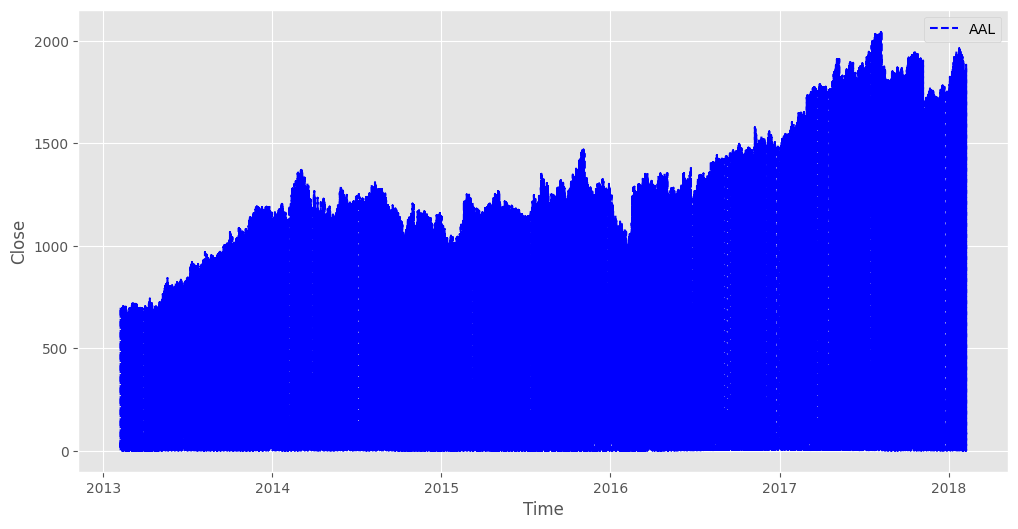

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pylab as plt
df = pd.read_csv('/kaggle/input/newwwwww/all_stocks_5yr.csv')
    
print("✅ Original Data:")
print(f"📐 Shape: {df.shape}")
print(f"🧾 Columns: {df.columns.tolist()}")
print("\n🔍 Sample Data:")
print(df.head())

# Drop rows with missing values (if any)
df = df.dropna()

# Convert and sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

aapl_df = df[df['Name'] == 'AAL'].copy()
aapl_df.set_index('date', inplace=True)  # Set date as index for time-based operations
print(f"AAL Stock Data Shape before: {aapl_df.shape}")
#print(aapl_df.head())
df.describe()


# Select features and target
feature_cols = ['open', 'high', 'low', 'close', 'volume']
target_col = 'close'

features = aapl_df[feature_cols].values.astype(np.float32)
target = aapl_df[target_col].values.astype(np.float32)

# Normalize features and target separately
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

# Create sequences with multiple features
def create_sequences(features, target, seq_length, pred_length):
    X, y = [], []
    for i in range(len(features) - seq_length - pred_length + 1):
        X.append(features[i:i+seq_length])  # Shape: (seq_length, num_features)
        y.append(target[i+seq_length:i+seq_length+pred_length])  # Shape: (pred_length,)
    return np.array(X), np.array(y)

SEQ_LENGTH = 5
PRED_LENGTH = 1

X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH, PRED_LENGTH)
total_size = len(X)
train_size = int(0.7 * total_size)  # 60% training
val_size = int(0.15 * total_size)    # 20% validation
# test_size = total_size - train_size - val_size (remaining 20%)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Dataset sizes:")
print(f"Training: {X_train.shape[0]} sequences")
print(f"Validation: {X_val.shape[0]} sequences")
print(f"Testing: {X_test.shape[0]} sequences")

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break
plt.figure(figsize=(12, 6))
plt.plot(df['date'],df['close'],'--b',label="AAL")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close')
plt.show()

In [58]:
import torch
import torch.nn as nn

class Add_Norm(nn.Module):
    def __init__(self, d_model, dropout, residual=True):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.residual = residual
    
    def forward(self, new, old):
        if self.residual:
            return self.norm(old + self.dropout(new))
        return self.norm(self.dropout(new))

class BimambaEncoderLayer(nn.Module):
    def __init__(self, d_model, d_conv, d_state, expand, 
                 b_d_conv, b_d_state, b_expand, dropout, d_ff, 
                 activation="relu", residual=True):
        super().__init__()
        # Mamba blocks (assumed defined elsewhere)
        self.mamba_forward = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        )
        self.mamba_backward = Mamba(
            d_model=d_model, d_state=b_d_state, d_conv=b_d_conv, expand=b_expand
        )
        # Normalization (pre-norm)
        self.norm = nn.LayerNorm(d_model)
        # Add/Norm layers
        self.addnorm1 = Add_Norm(d_model, dropout, residual=False)
        self.addnorm2 = Add_Norm(d_model, dropout, residual=False)
        self.addnorm3 = Add_Norm(d_model, dropout, residual=residual)
        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.addnorm4 = Add_Norm(d_model, dropout, residual=residual)

    def forward(self, x, mask=None):
        x_norm = self.norm(x)
        
        # Forward Mamba block
        out_fwd = self.mamba_forward(x_norm)
        out_fwd = self.addnorm1(out_fwd, x)  # residual=False
        
        # Backward Mamba block
        rev_input = x_norm.flip(dims=[1])
        # rev_mask = mask.flip(dims=[1]) if mask is not None else None  # Not used because Mamba lacks mask support
        
        out_bwd = self.mamba_backward(rev_input)  # no mask passed
        out_bwd = out_bwd.flip(dims=[1])
        out_bwd = self.addnorm2(out_bwd, x)  # residual=False
        
        # Combine forward and backward outputs
        out = out_fwd + out_bwd
        out = self.addnorm3(out, x)  # residual=True
        
        # Feed Forward Network
        ffn_out = self.ffn(out)
        return self.addnorm4(ffn_out, out)  # residual=True

class StockMambaEncoder(nn.Module):
    def __init__(self, input_features=5, d_model=64, n_layer=2, 
                 d_conv=2, d_state=16, expand=2, 
                 b_d_conv=2, b_d_state=16, b_expand=2,
                 dropout=0.1, d_ff=512):
        super().__init__()
        # Input projection
        self.input_proj = nn.Linear(input_features, d_model)
        # Encoder layers
        self.layers = nn.ModuleList([
            BimambaEncoderLayer(
                d_model=d_model, d_conv=d_conv, d_state=d_state, expand=expand,
                b_d_conv=b_d_conv, b_d_state=b_d_state, b_expand=b_expand,
                dropout=dropout, d_ff=d_ff
            ) for _ in range(n_layer)
        ])
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        #print(x.shape)
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)  # mask is accepted but not used for now
        return x


In [59]:
class MambaEncoder(nn.Module):
    def __init__(self, input_features=5, d_model=64):
        super(MambaEncoder, self).__init__()  # Fixed super call
        
        # Encoder processes the sequence
        self.encoder = StockMambaEncoder(
            input_features=input_features,
            d_model=d_model
        )
        
        # Context vector creation (to summarize sequence)
        self.context = nn.Sequential(
            nn.Linear(d_model * 5, d_model),  # 5 days sequence
            nn.ReLU()
        )
        
        # Decoder (outputs single value for next day's close)
        self.decoder = nn.Linear(d_model, 1)
        
        # Initialize weights
        self.init_weights()
        self.d_model = d_model

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        # Also initialize encoder weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.uniform_(-initrange, initrange)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, src):
        # Encode the input sequence (shape: [batch, 5, features])
        encoder_output = self.encoder(src)  # Output shape: [batch, 5, d_model]
        
        # Flatten the sequence to create context vector
        batch_size = encoder_output.size(0)
        flattened = encoder_output.view(batch_size, -1)  # [batch, 5 * d_model]
        
        # Create context vector
        context = self.context(flattened)  # [batch, d_model]
        
        # Predict next day's close
        output = self.decoder(context)  # [batch, 1]
        
        return output.squeeze(-1)  # [batch]


# Hyperparameters
input_features = 5  # open, high, low, close, volume
d_model = 256        # Dimension of the model
nhead = 8           # Number of attention heads
num_layers = 6     # Number of transformer layers
dropout = 0.2       # Dropout rate
learning_rate = 0.001
num_epochs = 50

# Initialize model, loss, and optimizer
model = MambaEncoder(input_features, d_model)

Epoch   | Train Loss   | Val Loss   | Time   | Status
--------------------------------------------------


1       | 0.006063 | 0.006286 | 0.84s | ✅ Improved


2       | 0.005078 | 0.004234 | 0.81s | ✅ Improved


3       | 0.003947 | 0.004132 | 0.82s | ✅ Improved


4       | 0.003288 | 0.005802 | 0.77s | ⏳ No improvement


5       | 0.005414 | 0.007739 | 0.77s | ⏳ No improvement


6       | 0.005945 | 0.003716 | 0.79s | ✅ Improved


7       | 0.006350 | 0.013075 | 0.77s | ⏳ No improvement


8       | 0.005077 | 0.006202 | 0.77s | ⏳ No improvement


9       | 0.005182 | 0.006495 | 0.78s | ⏳ No improvement


10      | 0.004444 | 0.007059 | 0.80s | ⏳ No improvement


11      | 0.003917 | 0.003808 | 0.80s | 🛑 Early Stop
Early stopping at epoch 11

Training Complete!
Best Validation Loss: 0.003716


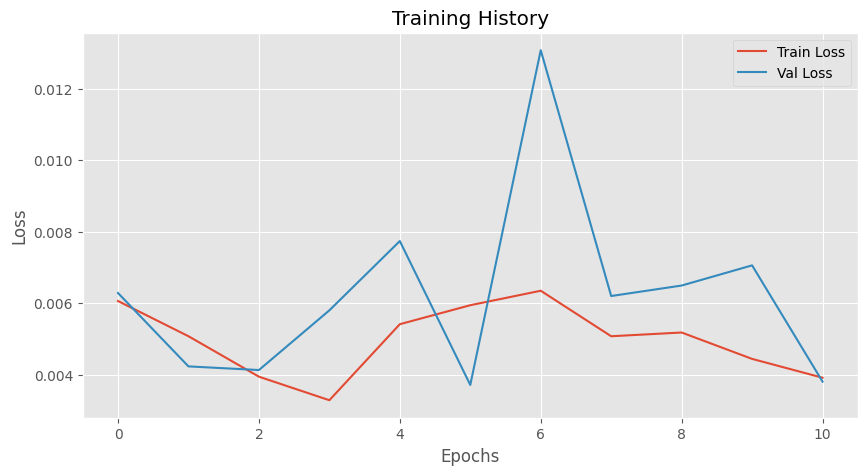

In [78]:
from tqdm import tqdm
import time
# Fix seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def train_modell(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, patience=5):
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # Better regularization
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
    
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    # Training header
    print(f"{'Epoch':<7} | {'Train Loss':<12} | {'Val Loss':<10} | {'Time':<6} | Status")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        train_loss = 0
        
        # Create progress bar for batches
        with tqdm(train_loader, unit="batch", leave=False) as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            for X_batch, y_batch in tepoch:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.squeeze())
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                # Update progress bar
                tepoch.set_postfix(loss=loss.item())
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_loss += criterion(outputs, y_val.squeeze()).item()
        
        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_transformer.pth')
            status = "✅ Improved"
        else:
            patience_counter += 1
            status = "⏳ No improvement"
            if patience_counter >= patience:
                status = "🛑 Early Stop"
        
        # Print epoch summary
        epoch_time = time.time() - epoch_start
        print(f"{epoch+1:<7} | {train_loss:.6f} | {val_loss:.6f} | {epoch_time:.2f}s | {status}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Final training report
    print("\nTraining Complete!")
    print(f"Best Validation Loss: {best_loss:.6f}")
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    
    return model


trained_model = train_modell(
        model, 
        train_loader, 
        val_loader,
        num_epochs=50,
        learning_rate=0.001,
        patience=5
    )


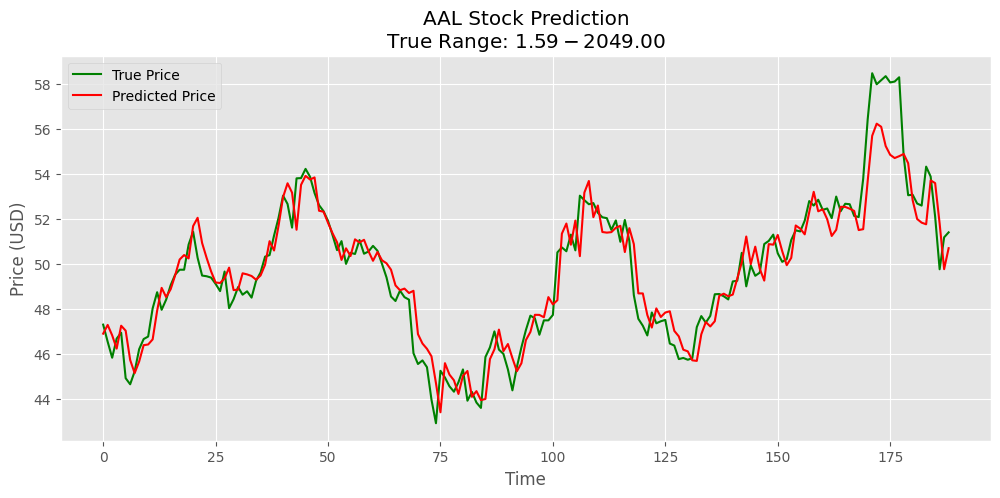


Normalized Metrics:
RMSE: 0.0991
MAE: 0.0726
R²: 0.8853

Denormalized Metrics (USD):
RMSE: $1.09 (1.3% of mean price)
MAE: $0.80
MAPE (>$5 prices): 1.59%


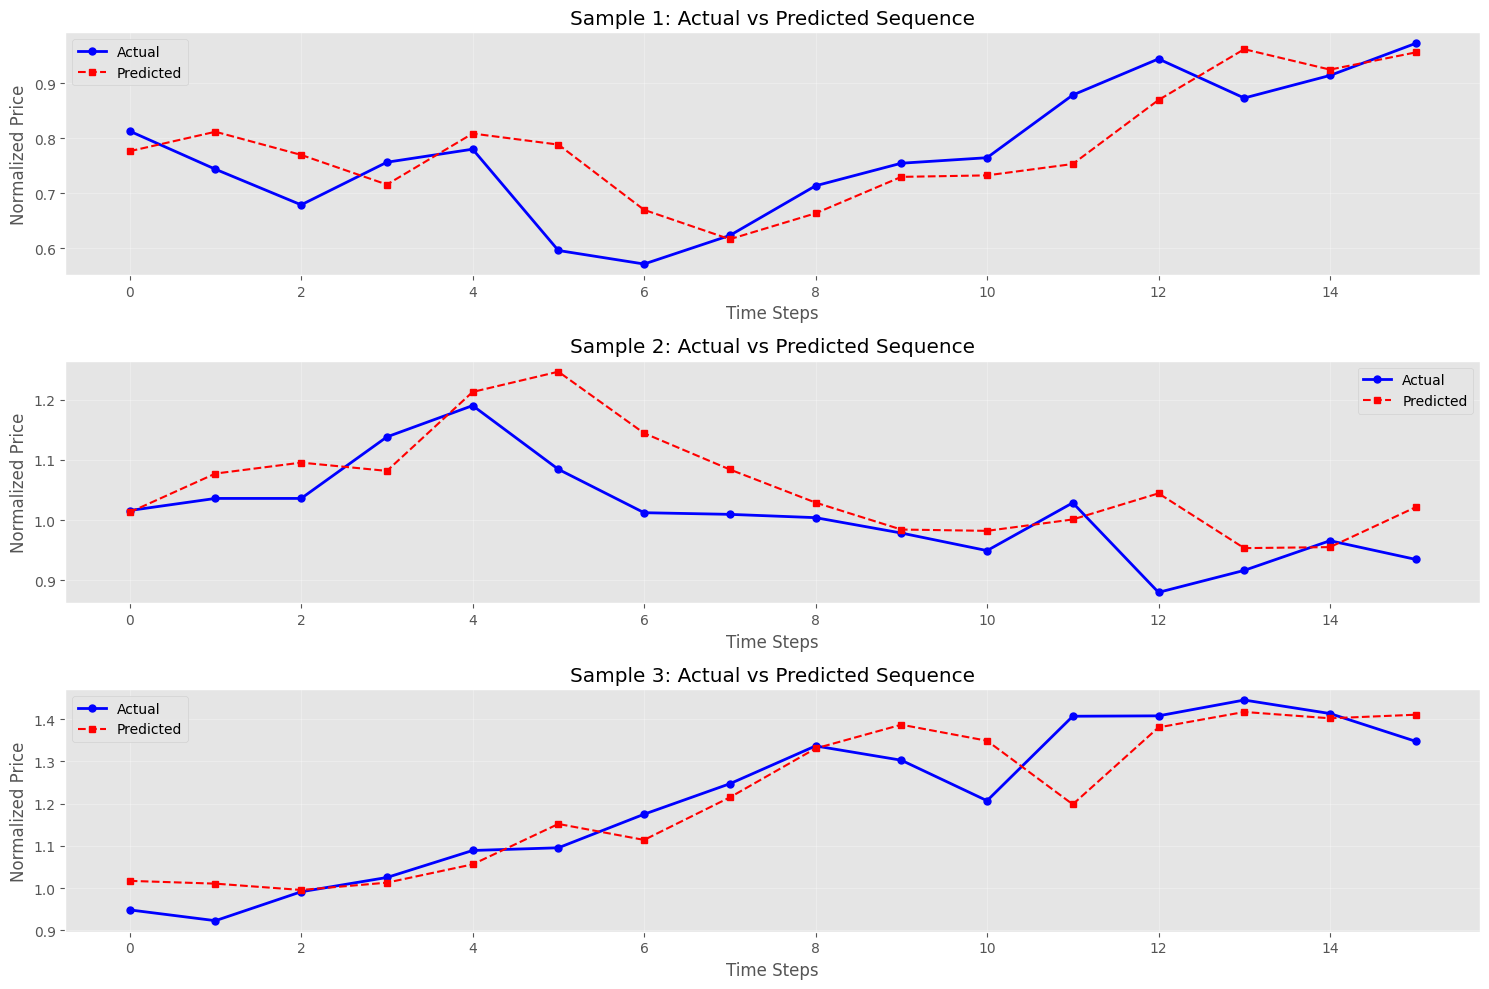

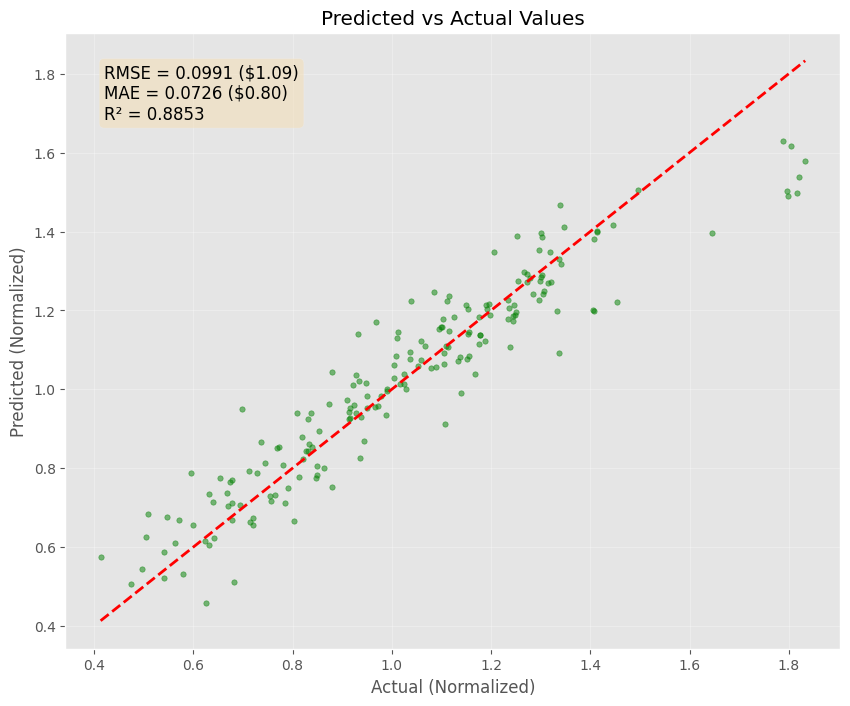

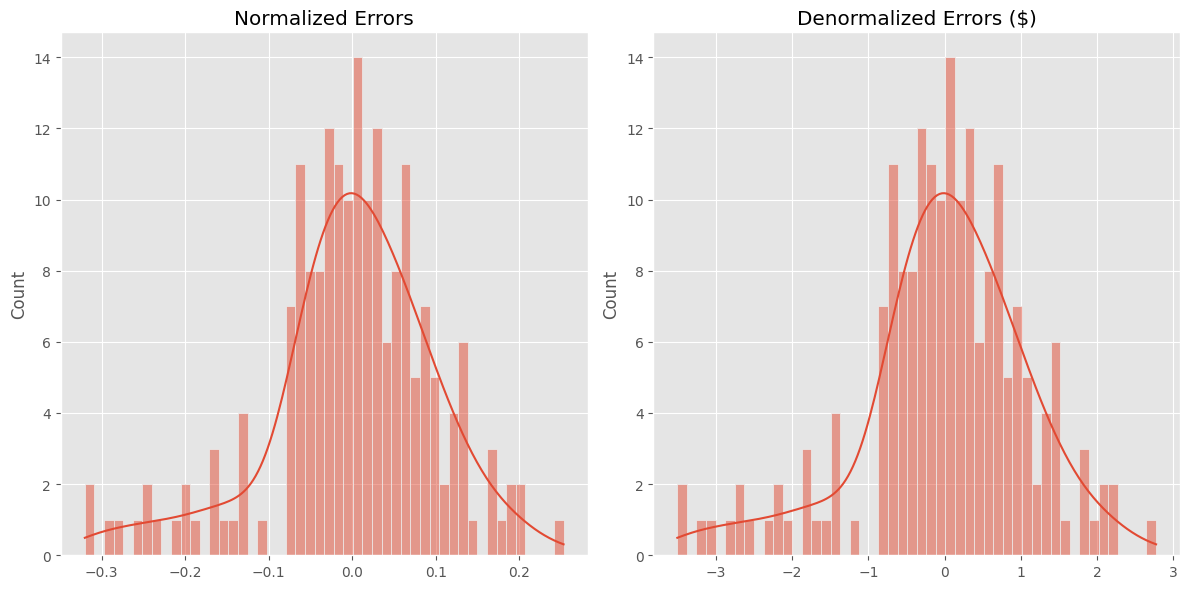

In [79]:
def test_mod(model, test_loader, target_scaler, original_prices_df):
    """
    Comprehensive testing function with metrics and visualizations
    Args:
        model: Trained transformer model
        test_loader: Test data loader
        target_scaler: Fitted target scaler
        original_prices_df: DataFrame with original prices for reference
    """
    model.eval()
    all_predictions = []
    all_ground_truth = []
    
    # Store for sequence plotting
    sequence_preds = []
    sequence_actuals = []
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test , y_test = X_test.to(device) , y_test.to(device)
            outputs = model(X_test)
            all_predictions.extend(outputs.cpu().numpy())
            all_ground_truth.extend(y_test.squeeze().cpu().numpy())
            
            # Store last 3 sequences for plotting
            if len(sequence_preds) < 3:
                sequence_preds.append(outputs.cpu().numpy())
                sequence_actuals.append(y_test.squeeze().cpu().numpy())
    
    # Convert to numpy arrays
    y_pred = np.array(all_predictions)
    y_true = np.array(all_ground_truth)
    
    # Inverse transform if scaler provided
    y_pred_denorm = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_true_denorm = target_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    original_mean = original_prices_df['close'].mean()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    rmse_denorm = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    
    # Calculate MAPE only for prices > $5 to avoid division by small numbers
    valid_prices_mask = y_true_denorm > 5
    mape_denorm = np.mean(np.abs((y_true_denorm[valid_prices_mask] - y_pred_denorm[valid_prices_mask]) / 
                         y_true_denorm[valid_prices_mask])) * 100

    # 1. Time-series comparison plot with USD values
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_denorm, label="True Price", color='green')
    plt.plot(y_pred_denorm, label="Predicted Price", color='red')
    plt.title(f"AAL Stock Prediction\nTrue Range: ${original_prices_df['close'].min():.2f}-${original_prices_df['close'].max():.2f}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print metrics
    print(f"\nNormalized Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    print(f"\nDenormalized Metrics (USD):")
    print(f"RMSE: ${rmse_denorm:.2f} ({(rmse_denorm/original_mean)*100:.1f}% of mean price)")
    print(f"MAE: ${mae_denorm:.2f}")
    print(f"MAPE (>$5 prices): {mape_denorm:.2f}%")

    # 2. Sample sequence plots
    plt.figure(figsize=(15, 10))
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.plot(sequence_actuals[i], 'b-o', label='Actual', linewidth=2, markersize=5)
        plt.plot(sequence_preds[i], 'r--s', label='Predicted', linewidth=1.5, markersize=5)
        plt.title(f"Sample {i+1}: Actual vs Predicted Sequence")
        plt.xlabel("Time Steps")
        plt.ylabel("Normalized Price")
        plt.grid(alpha=0.3)
        plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Scatter plot with metrics
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, c='green', s=15)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual (Normalized)")
    plt.ylabel("Predicted (Normalized)")
    plt.grid(alpha=0.3)
    
    textstr = '\n'.join((
        f'RMSE = {rmse:.4f} (${rmse_denorm:.2f})',
        f'MAE = {mae:.4f} (${mae_denorm:.2f})',
        f'R² = {r2:.4f}'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                  fontsize=12, verticalalignment='top', bbox=props)
    plt.show()

    # 4. Error distribution plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    errors_norm = y_pred - y_true
    sns.histplot(errors_norm, kde=True, bins=50)
    plt.title('Normalized Errors')
    
    plt.subplot(1, 2, 2)
    errors_denorm = y_pred_denorm - y_true_denorm
    sns.histplot(errors_denorm, kde=True, bins=50)
    plt.title('Denormalized Errors ($)')
    plt.tight_layout()
    plt.show()

    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'rmse_denorm': rmse_denorm,
        'mae_denorm': mae_denorm,
        'mape_denorm': mape_denorm
    }

# Example usage:
test_results = test_mod(trained_model, test_loader, target_scaler, df)